<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF) Data Products</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run: 2023-09-18 <br>
LSST Science Pipelines version: Weekly 2023_37  <br>
Container size: medium <br>
Targeted learning level: intermediate <br>

**Description:** A demonstration of how to access `calexp` and `deepCoadd` PSF properties.

**Skills:** Use of single-epoch and coadded PSF models.

**LSST Data Products:**   DP0.2 collection: `2.2i/runs/DP0.2`. Dataset types: `calexp`, `deepCoadd`.  Catalogs: `dp02_dc2_catalogs.Object`, `dp02_dc2_catalogs.Source`.

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools, lsst.pipe.base

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Jeff Carlin, Ryan Lau, and the Rubin Community Science Team for DP0.2. The functions for studying the PSF image profile are built upon the rapid-analysis code originally created by Merlin Fisher-Levine to characterize the Point Spread Function (PSF) of the Rubin Auxiliary Telescope LSST Atmospheric Transmission and Slitless Spectrograph (LATISS) images.
This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

The Point Spread Function (PSF) can be understood as a function that describes how a bundle of rays, initially converging on a single point, spreads out spatially around that point (in simplest terms, the PSF can be thought of as how light from an astronomical point source is "spread out" in an image).

To accurately characterize the PSF, it is common to analyze the observed images of stars, which act as point sources before being distorted by the PSF.
This analysis helps determine the convolution kernel, representing the size and shape of the blurring effect caused by the PSF.
Accurate PSF modeling is crucial because any inaccuracies in understanding these effects can lead to erroneous conclusions about fundamental aspects of the universe (e.g., the properties of dark matter and dark energy).
Therefore, understanding and characterizing the PSF is essential to properly interpret and extract reliable information from astronomical observations.

This tutorial demonstrates how the PSF is measured by the LSST Science Pipelines for all images,
with a focus on `calexp` and `deepCoadd` images.
It provides an overview of the PSF-related information and data products that are available for LSST images,
and shows how to calculate PSF profiles and contours, along with other properties such as size.

**How are PSFs measured by the LSST Science Pipelines?**

1. The initial stage in processing LSST science observations involves Instrument Signature Removal (ISR).
This encompasses fundamental detrending operations like flat-fielding, bias subtraction, fringe correction,
and rectification of flawed and oversaturated pixels. 

2. Subsequently, the focus shifts to characterizing single-epoch direct images, constructing models that 
depict the observational system and its conversion of the true celestial scene into the observed image.
This process encompasses background subtraction, PSF modeling, addressing cosmic ray effects, 
applying aperture corrections, and source measurement. 

3. After segregating stars and galaxies, the PSF model in single-epoch images is assembled using data from a star catalog. 

The LSST Science Pipelines have partially transitioned to using the [PIFF (PSF in the Full-Field of View)](https://rmjarvis.github.io/Piff/_build/html/index.html) code for PSF modeling in the full field of view. However, the DP0.2 PSF models were generated using the Point Spread Function Extractor, [PSFEx](https://ui.adsabs.harvard.edu/abs/2013ascl.soft01001B/abstract), software.
Understanding or using these codes is not necessary for completing this tutorial, nor for doing PSF
analysis with the LSST images.

### 1.1. Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), 
[numpy](http://www.numpy.org/), and [scipy](https://scipy.org/) libraries are widely used 
Python libraries for plotting, scientific computing, and scientific analysis.
The `lsst.daf.butler` library is used to access data products via the butler, 
and the `lsst.afw.display` library provides access to image visualization routines.
The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

<!--- and [astropy](http://www.astropy.org/) --->

<!--- The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs. --->

<!--- The `lsst.afw.image` provide visualization tools. --->

<!--- The `lsst.afw.analysis.tools` library provides acces to analysis tools.--->

<!--- The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container. --->

<!--- [treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree)). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. --->

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import skew

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees

### 1.2. Define parameters and functions

The following functions and parameters are defined once, and used throughout this notebook.

> **Notice: It is not necessary to read and understand all functions!**

It is OK to simply execute all of the cells in Section 1.2 and move on to Section 2.

Define the Butler instance for DP0.2 in order to access images with this notebook.

In [2]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')

The following cell will set a standard figure size and `afwDisplay` backend to use throughout the notebook.

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

**Constant**: `SIGMA_TO_FWHM` 

Defines the convertion factor between the standard deviation `sigma` of a Gaussian function a the full-withd at half-maximum (FWHM): $2\sqrt{2\ln(2)}$

In [4]:
SIGMA_TO_FWHM = 2.0*np.sqrt(2.0*np.log(2.0))

**Function**: `gauss`

Defines a one-dimensional Gaussian profile.

In [5]:
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

**Function**: `getPsfProperties`

Given a PSF model (`lsst.meas.extensions.psfex.PsfexPsf`) and a coordinate where the model is being evaluated
(`lsst.geom.Point2D`) this functions returns the PSF FWHM, flux from aperture photometry, 
peak value of the normalized PSF (the PSF is normalized to a sum of 1), and size of the PSF postage stamp.

In [6]:
def getPsfProperties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
        fwhm : `float`
            Full-width at half maximum: PSF determinant radius
            from SDSS adaptive moments matrix (sigma) times
            SIGMA_TO_FWHM.
        ap_flux : `float`
            PSF flux from aperture photometry weighted
            by a sinc function.
        peak : `float`
            Peak PSF value.
        dims : `lsst.geom.ExtendI`
            PSF postage stamp dimensions.
    """
    sigma = psf.computeShape(point).getDeterminantRadius()
    fwhm = sigma * SIGMA_TO_FWHM
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    dims = psf.computeImage(point).getDimensions()

    print(f"PSF FWHM: {fwhm:.4} pix \n"
          f"PSF flux from aperture photometry: {ap_flux:.4} \n"
          f"Peak PSF value: {peak:.4} \n"
          f"PSF postage stamp dimensions: {dims} \n")

    return (sigma, ap_flux, peak, dims)

**Function**: `plotRadialAverage`

Given an image of the PSF (`lsst.afw.image.ExposureF`), this function 
plots the azimuthally-averaged radial profile of the PSF, and fits a Gaussian function to it.

In [7]:
def plotRadialAverage(exp, ax=None):
    """
    Function to plot the radial average of a point spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape
    center = np.array([xlen / 2, ylen / 2])
    distances = []
    values = []

    for i in range(xlen):
        for j in range(ylen):
            value = data[i, j]
            dist = np.linalg.norm(np.array([i, j]) - center)
            if dist <= xlen / 2:
                values.append(value)
                distances.append(dist)

    peakPos = 0
    amplitude = np.max(values)
    width = 10

    bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

    try:
        pars, pCov = curve_fit(gauss, distances, values,
                               [amplitude, peakPos, width], bounds=bounds)
        pars[0] = np.abs(pars[0])
        pars[2] = np.abs(pars[2])
    except RuntimeError:
        pars = None

    if ax is None:
        ax = plt.gca()

    ax.plot(distances, values, 'x', label='Radial average')

    if pars is not None:
        fitAmp = pars[0]
        fitGausMean = pars[1]
        fitFwhm = pars[2] * SIGMA_TO_FWHM
        fitline = gauss(distances, *pars)

        x_fit = np.linspace(-np.max(distances), np.max(distances), 100)
        y_fit = gauss(x_fit, *pars)
        skewness = skew(y_fit, axis=0, bias=True)

        ax.plot(distances, fitline,
                label=f" Gaussian Fit \n Amp: {fitAmp:.3f}"
                      f"\n Position: {fitGausMean:.2f}"
                      f"\n FWHM: {fitFwhm:.2f}"
                      f"\n \n Skewness: {skewness:.2f}")

    ax.set_ylabel('Flux (ADU)')
    ax.set_xlabel('Radius (pix)')
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
    ax.legend()
    ax.set_title("Azimuthally-averaged radial profile")

    return ax

**Function**: `plotCurveOfGrowth`

Given an image of the PSF (`lsst.afw.image.ExposureF`), this function
plots the encircled energy of the PSF as a function of radius (curve of growth).

In [8]:
def plotCurveOfGrowth(exp, ax=None):
    """
    Function to plot the curve of growth of a point
    spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape
    center = np.array([xlen / 2, ylen / 2])
    distances = []
    values = []

    for i in range(xlen):
        for j in range(ylen):
            value = data[i, j]
            dist = np.linalg.norm(np.array([i, j]) - center)
            if dist <= xlen / 2:
                values.append(value)
                distances.append(dist)

    d = np.array([(r, v) for (r, v) in sorted(zip(distances, values))])
    radii = d[:, 0]
    values = d[:, 1]
    cum_fluxes = np.cumsum(values)
    cum_fluxes_norm = cum_fluxes / np.max(cum_fluxes)

    if ax is None:
        ax = plt.gca()

    ax.plot(radii, cum_fluxes_norm, markersize=10)
    ax.set_ylabel('Encircled flux (%)')
    ax.set_xlabel('Radius (pix)')
    #ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')
    ax.set_title("Encircled flux")

    return ax

**Function**: `plotContours` 

Given an image of the PSF (`lsst.afw.image.ExposureF`) and, optionally,
the plot axis and number of contours (`nContours`), this function
plots the two-dimensional contous of the PSF postage stamp.

In [9]:
def plotContours(exp, ax=None, nContours=10):
    """
    Function to plot contour lines of a point spread function (PSF) image.

    Parameters
    ----------
    exp : `lsst.afw.image.ExposureF`
        The PSF image exposure.
    ax : `matplotlib.axes.Axes`, optional
        If provided, the plot will be drawn on this axis (default is None).
    nContours : int, optional
        The number of contour lines to plot (default is 10).

    Returns
    -------
    ax : `matplotlib.axes.Axes`
        The axis on which the plot was drawn.
    """
    data = exp.array
    xlen, ylen = data.shape

    vmin = np.percentile(data, 0.1)
    vmax = np.percentile(data, 99.9)
    lvls = np.linspace(vmin, vmax, nContours)

    xx, yy = np.meshgrid(np.linspace(-xlen / 2, xlen / 2, xlen),
                         np.linspace(-ylen / 2, ylen / 2, ylen))

    if ax is None:
        ax = plt.gca()

    ax.contour(xx, yy, data, levels=lvls)
    ax.tick_params(which="both", direction="in", top=True,
                   right=True, labelsize=8)
    ax.set_aspect("equal")
    ax.set_xlabel('x (pix)')
    ax.set_ylabel('y (pix)')
    ax.set_title("Contour plot")
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

    return ax

## 2. Explore the PSF for a `calexp` image

Recall that a `calexp` is the image from a single detector for a single processed visit image.

### 2.1. Obtain a `calexp`

Retrieve a particular single `calexp` image from the butler using a known `visit` and `detector`
(this is the the same image as used in section 2 of DP0.2 Notebook Tutorial 3a).

In [10]:
datasetType = 'calexp'
dataId = {'visit': 192350, 'detector': 175}
calexp = butler.get(datasetType, dataId=dataId)

Display the `calexp`.

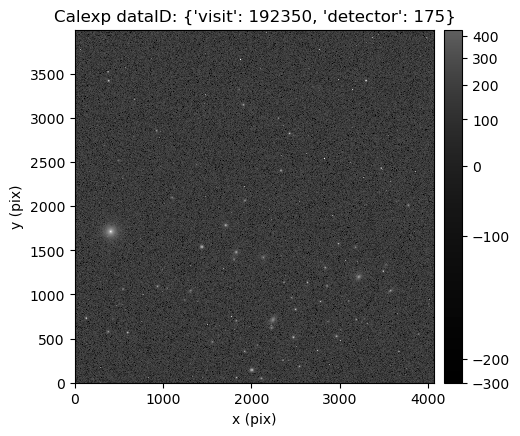

In [11]:
fig = plt.figure(figsize=(5, 5))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.title(f'Calexp dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

> **Figure 1:** *The plot above displays a 2D image of the `calexp` with coordinates ranging from 0 to 4000 pixels in both axes,
and with a contrast bar ranging from -300 to 400 digital units.
Point and extended sources are scattered around the image.*

### 2.2. Extract PSF information

Extract the PSF model from the exposure information, which is obtained from the `calexp` object itself.

In [12]:
info_calexp = calexp.getInfo()
psf_calexp = info_calexp.getPsf()

**Option:** explore the methods available for `info_calexp` by uncommenting the following cell (removing the `#`),
putting the cursor after the period, pressing the tab key, and scrolling through the list of options.
Find that `getPsf` is just one option.

In [13]:
# info_calexp.

**Option:** explore the methods available for `psf_calexp`.

In [14]:
# psf_calexp.

Pick the specific point in the image with coordinates `(x, y) = (2000, 3500)` and use
it to define the `point_tuple` variable.

Convert the `point_tuple` into a `Point2D` object.

In [15]:
point_tuple = (2000, 3500)
point_image = Point2D(point_tuple)

Pass the `psf_calexp` retrieved from the image, and the defined `point_image` coordinates,
to the `getPsfProperties` helper function in order to obtain PSF properties at that location in the `calexp` image.

The returned PSF properties are size (FWHM in pixels), 
aperture photometry flux (within a 1-sigma radius), 
peak flux value (recall that the PSF has been normalized to a sum of 1), 
and the dimensions of the PSF postage stamp (illustrated below).

In [16]:
props = getPsfProperties(psf_calexp, point_image)

PSF FWHM: 3.795 pix 
PSF flux from aperture photometry: 0.3659 
Peak PSF value: 0.05834 
PSF postage stamp dimensions: (41, 41) 



### 2.3. Create and display PSF kernel images

Use the extracted PSF information to create and display postage stamps of the PSF using
two functions: `computeKernelImage`, which uses central pixels `(0, 0)`,
and `computeImage`, which accepts user-specified central pixels.


#### 2.3.1. Use `computeKernelImage`

Use the `computeKernelImage` method to retrieve the PSF kernel at the location of the `point_image` defined above
as a postage stamp with a center pixel of (0, 0).

First compute the kernel image, and then convert it to `exposureF` format.

In [17]:
psf_calexp_kernel = psf_calexp.computeKernelImage(point_image)
first_psf_image_calexp = psf_calexp_kernel.convertF()

Display the PSF postage stamp.

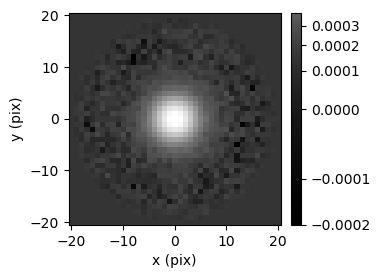

In [18]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_calexp)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

> **Figure 2:** *The plot above depicts the postage stamp (or cut-out) of the PSF model extracted from 
the `calexp` image using the `computeKernelImage` function.
The PSF is centered on the origin, with central pixel coordintes (0, 0).
The stamp is a square of 40 pixels per side that spans
from negative 20 to positive 20 pixels on each side.
The total flux in the PSF kernel has been normalized to sum to 1, and the color contrast bar
spans a range from approximately negative 0.0002 to about 0.0003.*

Note that with `computeKernelImage`, the postage stamp's coordinates are centered at the origin of the image.
The coordinates of this origin point are (0, 0), resulting in negative coordinates for the lower left point.

Print the coordinates for the lower left point of this postage stamp image.

In [19]:
print(first_psf_image_calexp.getXY0())

(-20, -20)


#### 2.3.2. Use `computeImage`

Use the `computeImage` method to retrieve the PSF kernel at the location of the `point_image` defined above
as a postage stamp with a center pixel defined by `point_image`.

(I.e., instead of a PSF kernel postage stamp centered on `0, 0`, as returned by `computeKernelImage`).

The `computeImage` function requires the astrometric solution for the `calexp`: in other words, 
the "World Coordinate System" (WCS) for the image is needed.
The WCS maps pixel coordinates to sky coordinates and is obtained from the exposure information
in a manner similar to how the PSF model was obtained.

Obtain the WCS from the `calexp`.

In [20]:
wcs_calexp = info_calexp.getWcs()

Compute the kernel image with `computeImage` and convert it to `exposureF` format.

In [21]:
second_psf_image_calexp = psf_calexp.computeImage(point_image).convertF()

Display the PSF postage stamp.

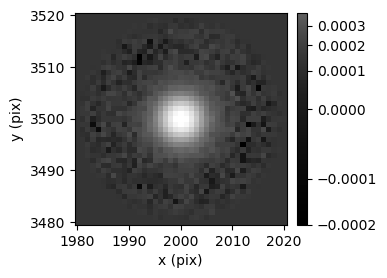

In [22]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_calexp)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

> **Figure 3:** *The plot above shows the postage stamp (or cut-out) of the PSF model 
from the `calexp` image obtained using `computeKernelImage`.
The PSF is centered on the user-specified pixel coordinates (2000, 3500).
The stamp is a square of 40 pixels per side that spans from 1980 to 2020 pixels on the `x` axis 
and from about 3480 to 3520 on the `y` axis.
The total flux in the PSF kernel has been normalized to sum to 1, and the color contrast bar spans a range from approximately negative 0.0002 to about 0.0003.*

Print the coordinates for the lower left point of this postage stamp image.

In [23]:
print(second_psf_image_calexp.getXY0())

(1980, 3480)


## 3. Explore the PSF for a `deepCoadd` image

### 3.1. Context for coadded image PSFs

When conducting multi-epoch surveys for static-sky science, the traditional method involves creating coadds.
This process entails resampling images from different observations onto a common grid and combining them 
to generate a single deeper image (called a `deepCoadd` within the context of the LSST Science Pipelines).
As part of the coaddition process, a coadded point spread function (PSF) model is established.
Handling PSF coadding with care is crucial to ensure a well-defined PSF.

One of the challenges in coadding PSFs arises from slight variations observed between PSFs in different visits.
Even minor differences make it practically impossible to accurately model the effective PSF of the coadd using
coadded star images.
Small positional shifts, known as dithers, that are used to fill the gaps between charge-coupled devices 
(CCDs) introduce disruptions in the effective PSF of the coadd.
As the number of dithers increases, the areas within the coadd with a continuous effective PSF become 
smaller, making it increasingly unlikely to find stars suitable for PSF modeling in each region.

For example, for the Hyper-Suprime Camera survey, 
[Bosch et al 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) 
use an approach that involves resampling and combining existing PSF models from the input 
images using the same coordinate transformations and weights applied to the image data.
The Hyper-Suprime Camera survey analysis pipeline is based on the LSST Science Pipelines code.

### 3.2. Obtain a `deepCoadd`

Obtain the `deepCoadd` which covers the same point in the sky in the same filter as
was used in Section 2, in order to better appreciate the differences between the 
`deepCoadd` and an individual `calexp` PSF model.

Retrieve the right ascension and declination coordinates of the point used in the previous section 
(which was stored in the variable `point_tuple`), and print the coordinates.

In [24]:
x, y = point_tuple
ra, dec = wcs_calexp.pixelToSky(x, y)
my_ra_deg = radToDeg(ra)
my_dec_deg = radToDeg(dec)
print(my_ra_deg, my_dec_deg)

53.01240743567535 -34.1195835309739


In order to retrieve a `deepCoadd` image, the butler will need the filter (`band`) to be specified in the `dataId`.

Obtain the band of the `calexp` used above, and print it.

In [25]:
my_band = info_calexp.getFilter().bandLabel
print(my_band)

i


Follow the steps outlined in Section 3.2 of the DP0.2 tutorial notebook 01 (Introduction to DP0.2) 
to determine the `tract` and `patch` of the `deepCoadd`, based on the sky coordinates.
Print the `tract` and `patch`.

In [26]:
my_spherePoint = SpherePoint(my_ra_deg*degrees,
                             my_dec_deg*degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)
my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()
print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

my_tract:  4225
my_patch:  3


Use the `tract`, `patch`, and `band` information to define the `dataId` for the desired `deepCoadd`.

Retrieve the `deepCoadd` from the butler.

In [27]:
datasetType = 'deepCoadd'
dataId = {'tract': my_tract, 'patch': my_patch, 'band': my_band}
coadd = butler.get(datasetType, dataId=dataId)

Display the `deepCoadd`.

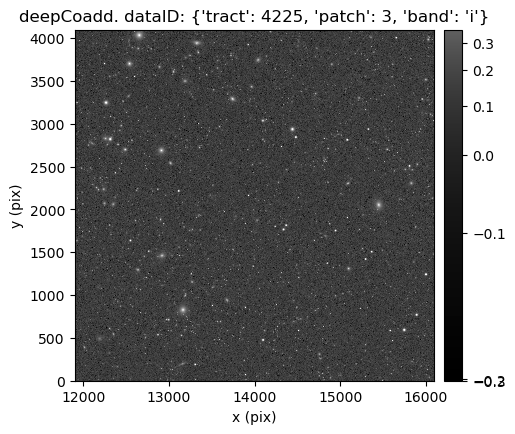

In [28]:
fig = plt.figure(figsize=(5, 5))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title(f'deepCoadd. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

> **Figure 4:** *The plot above displays the 2D image of the `deepCoadd` from the previous butler query.
Coordinates range from 12000 to 16000 pixels in the horizontal axis and 0 to 4000 pixels in the vertical axis.
The contrast bar ranges from negative 0.2 to 0.3 digital units. Point and extended sources are scattered around the image.
Many more sources can be seen in this `deepCoadd` than in the `calexp` at the same sky location, shown in Figure 1.*

### 3.3. Extract PSF information

Extract the PSF model from the `deepCoadd` object.

In [29]:
info_coadd = coadd.getInfo()
psf_coadd = info_coadd.getPsf()

Obtain the pixel coordinates in the `deepCoadd` that correspond to the same
sky coordinates (RA, Dec) used above 
(i.e., the sky coordinates corresponding to `calexp` pixel coordinates `(x, y) = (2000, 3500)`).

Retrieve the WCS for the `deepCoadd`, then convert the RA and Dec stored as `my_spherePoint` into
pixel coordinates for the `deepCoadd`, and store the pixel coordinates as `point_image`.

In [30]:
wcs_coadd = info_coadd.getWcs()
point_image = wcs_coadd.skyToPixel(my_spherePoint)
point_image

Point2D(12937.473803968331, 2324.9666227765465)

Pass the `deepCoadd` PSF model and desired pixel coordinates to the `getPsfProperties` helper function 
to obtain the PSF properties of size, aperture flux, peak flux, and postage stamp dimensions.

In [31]:
props_psf_coadd = getPsfProperties(psf_coadd, point_image)

PSF FWHM: 4.121 pix 
PSF flux from aperture photometry: 0.3591 
Peak PSF value: 0.0492 
PSF postage stamp dimensions: (57, 57) 



> **Notice:** The PSF FWHM for the `deepCoadd` is 4.1 pixels -- larger than the PSF FWHM for the `calexp` which was 3.8 pixels.
This indicates that we chose a `calexp` of better-than-average image quality, 
as the width of the `deepCoadd` FWHM
is approximately indicative of the average image quality.

### 3.4. Create and display PSF kernel images

#### 3.4.1. Use `computeKernelImage`

Use the `computeKernelImage` method to display the PSF kernel as a postage stamp with a center pixel of (0, 0).

First compute the kernel image, and then convert it to `exposureF` format.

In [32]:
psf_kernel_coadd = psf_coadd.computeKernelImage(point_image)
first_psf_image_coadd = psf_kernel_coadd.convertF()

Display the PSF postage stamp for the `deepCoadd`.

Note the higher signal-to-noise ratio for the `deepCoadd`, compared to the single `calexp` PSF image in Section 2.3.1.

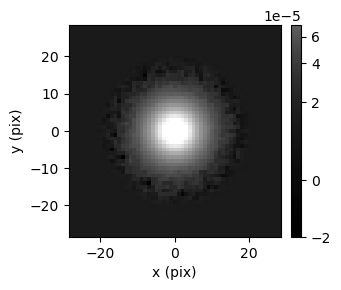

In [33]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_coadd)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

> **Figure 5:** *The plot above displays the postage stamp of the PSF model from the `deepCoadd` image 
obtained using `computeKernelImage`. 
The PSF is centered at pixel coordinates (0, 0).
The stamp is a square with sides of about 50 pixels, ranging from negative 25 to positive 25 pixels on both axes.
The contrast bar ranges from -1e-5 to 7e-5.*

Print the coordinates of the lower-left corner.

In [34]:
print(first_psf_image_coadd.getXY0())

(-28, -28)


#### 3.4.2. Use `computeImage`

Use the `computeKernelImage` method to display the PSF as a postage stamp with a center pixel of 
(12937.5, 2325.0).

In [35]:
second_psf_image_coadd = psf_coadd.computeImage(point_image).convertF()

Display the PSF postage stamp.

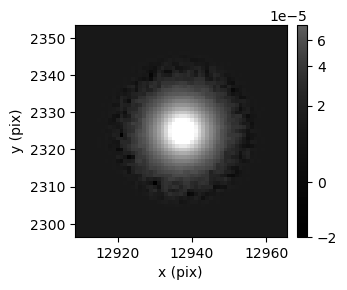

In [36]:
fig = plt.figure(figsize=(3, 3))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_coadd)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')
plt.show()

> **Figure 6:** *The plot above displays the postage stamp of the PSF model from the `deepCoadd` image 
obtained using `computeImage`. 
The PSF is centered at coordinates 12937.5, 2325.0 pixels.
Te stamp is a square with sides of about 50 pixels, ranging from 12910 to 12970 pixels on the horizontal axis
and 2300 to 2350 pixels on the vertical axis.
The contrast bar ranges from pixels values of negative 2e-5 to positive 7e-5.*

Print the coordinates of the lower-left corner.

In [37]:
second_psf_image_coadd.getXY0()

Point2I(12909, 2297)

## 4. Create PSF analysis plots

Use the functions `plotRadialAverage`, `plotCurveOfGrowth`, and `plotContours`, 
which are based on image quality code currently employed for the 
[swift PSF analysis of the LATISS images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) 
obtained by Rubin's AuxTel at Cerro Pachón, Chile.

### 4.1. Radial profile plots

Use the `plotRadialAverage` function to plot an azimuthally-averaged one dimensional PSF profile 
and fit it with a Gaussian function, for both the `calexp` and `deepCoadd` PSF images. 

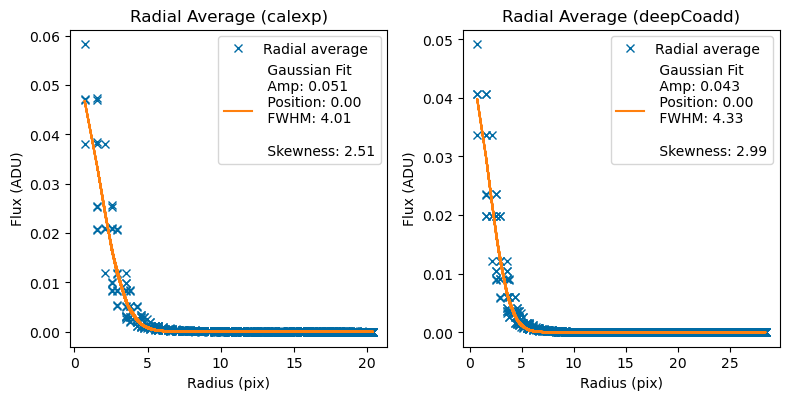

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotRadialAverage(first_psf_image_calexp, ax=axes[0])
ax1.set_title("Radial Average (calexp)")
ax2 = plotRadialAverage(first_psf_image_coadd, ax=axes[1])
ax2.set_title("Radial Average (deepCoadd)")
plt.tight_layout()
plt.show()

> **Figure 7:** *The plots above display the PSF kernel flux in ADU as a function of radius in pixels
from the center of the PSF (blue crosses), and the best-fit Gaussian function (orange line), 
for the PSF from the `calexp` (left) and the `deepCoadd` (right).
The legend contains the amplitude (peak flux), position (peak radial coordinate), 
and FWHM (in pixels), along with the [skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) of the Gaussian fit.*

As noted in Section 3.3, the FWHM of the `deepCoadd` PSF is larger than that for the selected `calexp`.

### 4.2. 2D contour plots

Use the `plotContours` function to create contour lines on the PSF image.
These contour lines depict regions of equal brightness. 
As above, show the contour plots for the `calexp` and `deepCoadd` PSFs side-by-side.

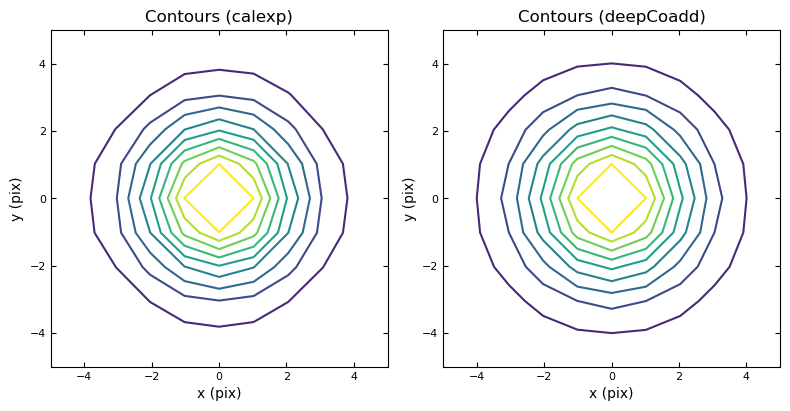

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotContours(first_psf_image_calexp, ax=axes[0])
ax1.set_title("Contours (calexp)")
ax1.set_xlim([-5, 5])
ax1.set_ylim([-5, 5])
ax2 = plotContours(first_psf_image_coadd, ax=axes[1])
ax2.set_title("Contours (deepCoadd)")
ax2.set_xlim([-5, 5])
ax2.set_ylim([-5, 5])
plt.tight_layout()
plt.show()

> **Figure 8:** *The plot above shows contour lines for the PSF kernel flux for the `calexp` (left) and 
the `deepCoadd` (right).
Recall that the PSF kernel fluxes have been normalized to an integrated flux of 1.
In both plots the inner and outer contour lines represent the 0.1 (yellow) and 99.9 (purple) percentile of the peak flux.*

As for the radial profiles, notice that the PSF kernel is broader for the `deepCoadd`.

### 4.3. Curve of growth (encircled energy)

Use the `plotCurveOfGrowth` function to calculate the cumulative amount of light enclosed by successively 
larger radii from the center of the PSF. 
This cumulative light measurement is normalized to the total light, resulting in a curve that reveals 
how light accumulates with increasing distance from the PSF center. 
As above, show the plots for the `calexp` and the `deepCoadd` PSFs side-by-side.

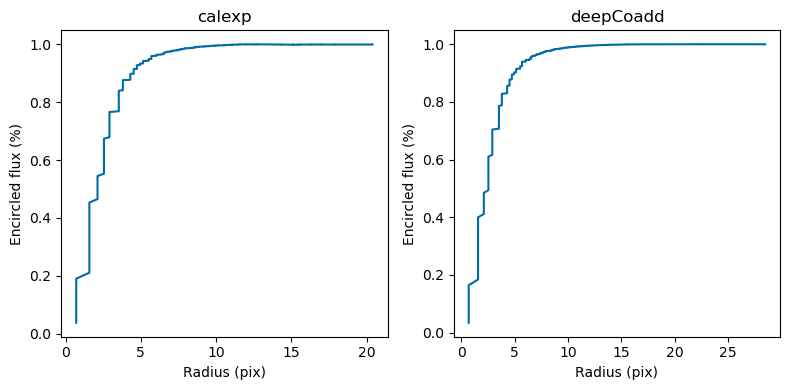

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1 = plotCurveOfGrowth(first_psf_image_calexp, ax=axes[0])
ax1.set_title("calexp")
ax2 = plotCurveOfGrowth(first_psf_image_coadd, ax=axes[1])
ax2.set_title("deepCoadd")
plt.tight_layout()
plt.show()

> **Figure 9:** *The plot above shows the curve of growth -- the fraction of the cumulative flux
as a function of radial offset from the center of the PSF -- for the `calexp` (left) and the 
`deepCoadd` (right).*

## 5. Exercises for the learner

**1. Co-plot `calexp` and `deepCoadd` PSF properties.**

In Section 4, the PSF properties are plotted side-by-side.
Use the code in the functions defined in Section 1.2 to co-plot the PSF properties for the
`calexp` and the `deepCoadd` in the same panel (same axis). 

HINT: This is relatively easy for the curve of growth in Section 4.3.
The code below works.
So does a similar approach for the radial profiles.
But co-plotting the contours is more challenging.

```
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
ax1 = plotCurveOfGrowth(first_psf_image_calexp, ax=axes)
ax1.set_title("calexp")
ax1 = plotCurveOfGrowth(first_psf_image_coadd, ax=axes)
ax1.set_title("deepCoadd")
plt.tight_layout()
plt.show()
```

For an even greater challenge, write new functions that *extract and return* 
the data being plotted (e.g., a new function that *returns* the `distances` and `values` 
arrays in `plotRadialAverage`, instead of plotting them and returning the axis),
then create your own plots with the returned arrays.

**2. Fit the PSF radial profiles with a non-Gaussian function.**

The function `plotRadialAverage` uses a Gaussian function to fit the averaged PSF profile.
Write a new function that uses a different (non-Gaussian) functional form for fitting the one-dimensional PSF radial profiles, 
such as the Moffat profile (as described in Section 3.1 of 
[Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).